In [55]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import numpy as np

map_m_to_q = {
    1 : 1, 2: 1, 3: 1, 4:2, 5: 2, 6: 2, 7: 3, 8:3 ,9:3, 10: 4, 11:4, 12:4
}
dir = "../data/"
cdf = pd.read_csv(dir+"data4columbia_credit.csv")
cdf.columns=['company','date','data']
cdf.date = pd.to_datetime(cdf.date)
cdf['month'] = cdf.date.apply(lambda x : x.month)
cdf['quarter'] = cdf.month.apply(lambda x : map_m_to_q[x])
cdf

,company,date,data,month,quarter
0,ef1bcca724f3,2016-01-01,266648.924500,1,1
1,ef1bcca724f3,2016-01-02,330109.961300,1,1
2,ef1bcca724f3,2016-01-03,248299.827200,1,1
3,ef1bcca724f3,2016-01-04,146428.339600,1,1
4,ef1bcca724f3,2016-01-05,146854.815500,1,1
...,...,...,...,...,...
116654,e2415cb7f63d,2022-11-05,1149.371612,11,4
116655,e2415cb7f63d,2022-11-06,890.458833,11,4
116656,e2415cb7f63d,2022-11-07,1233.454763,11,4
116657,e2415cb7f63d,2022-11-08,2478.464933,11,4


/usr/local/anaconda3/envs/wellington/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


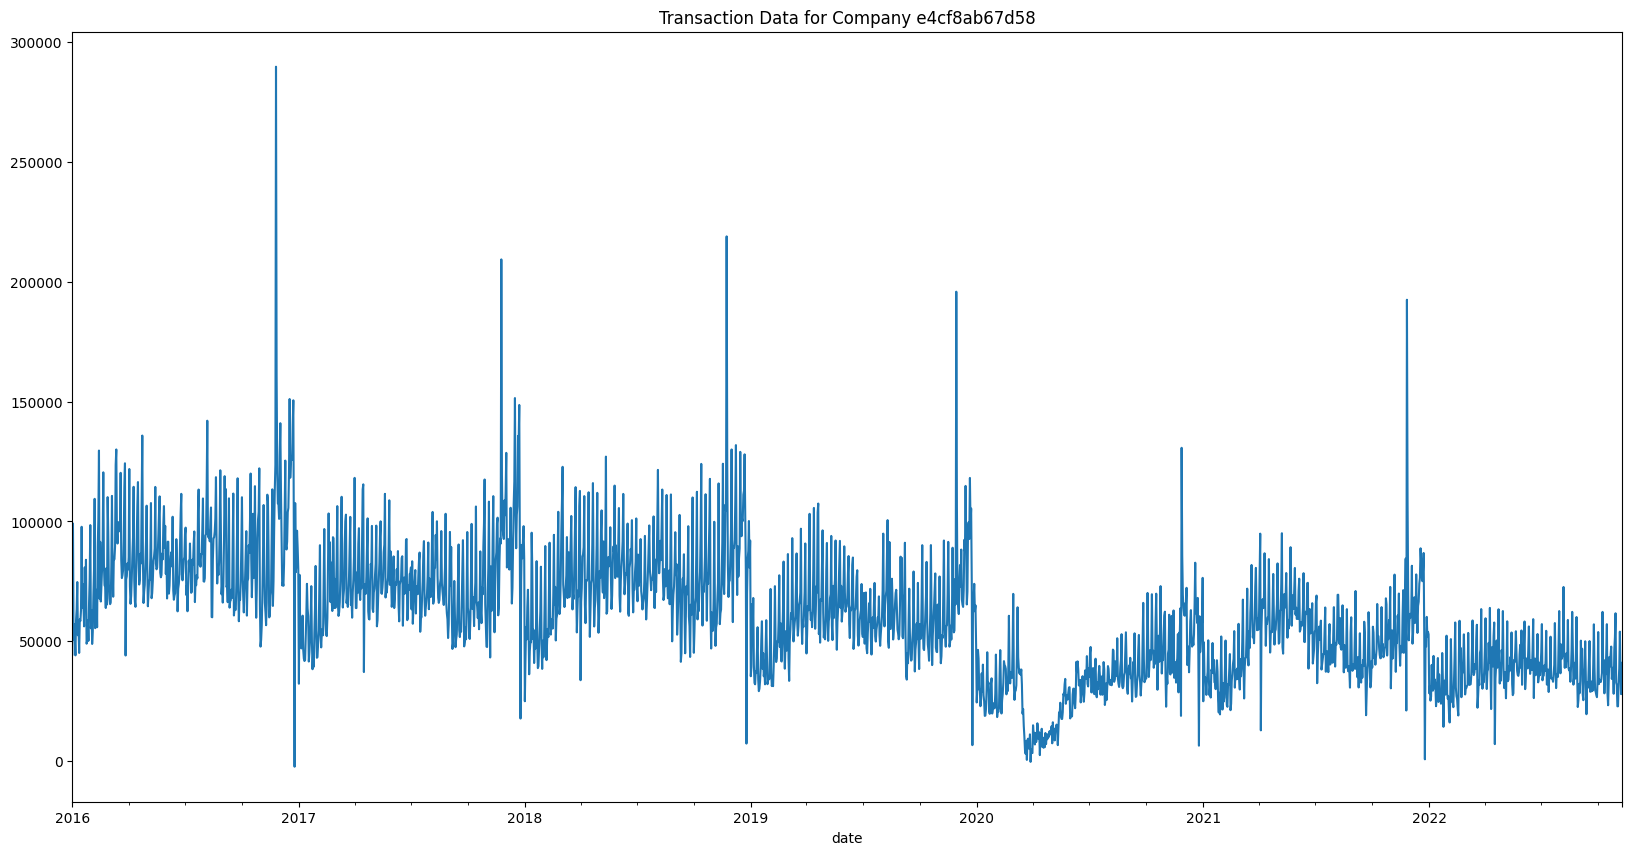

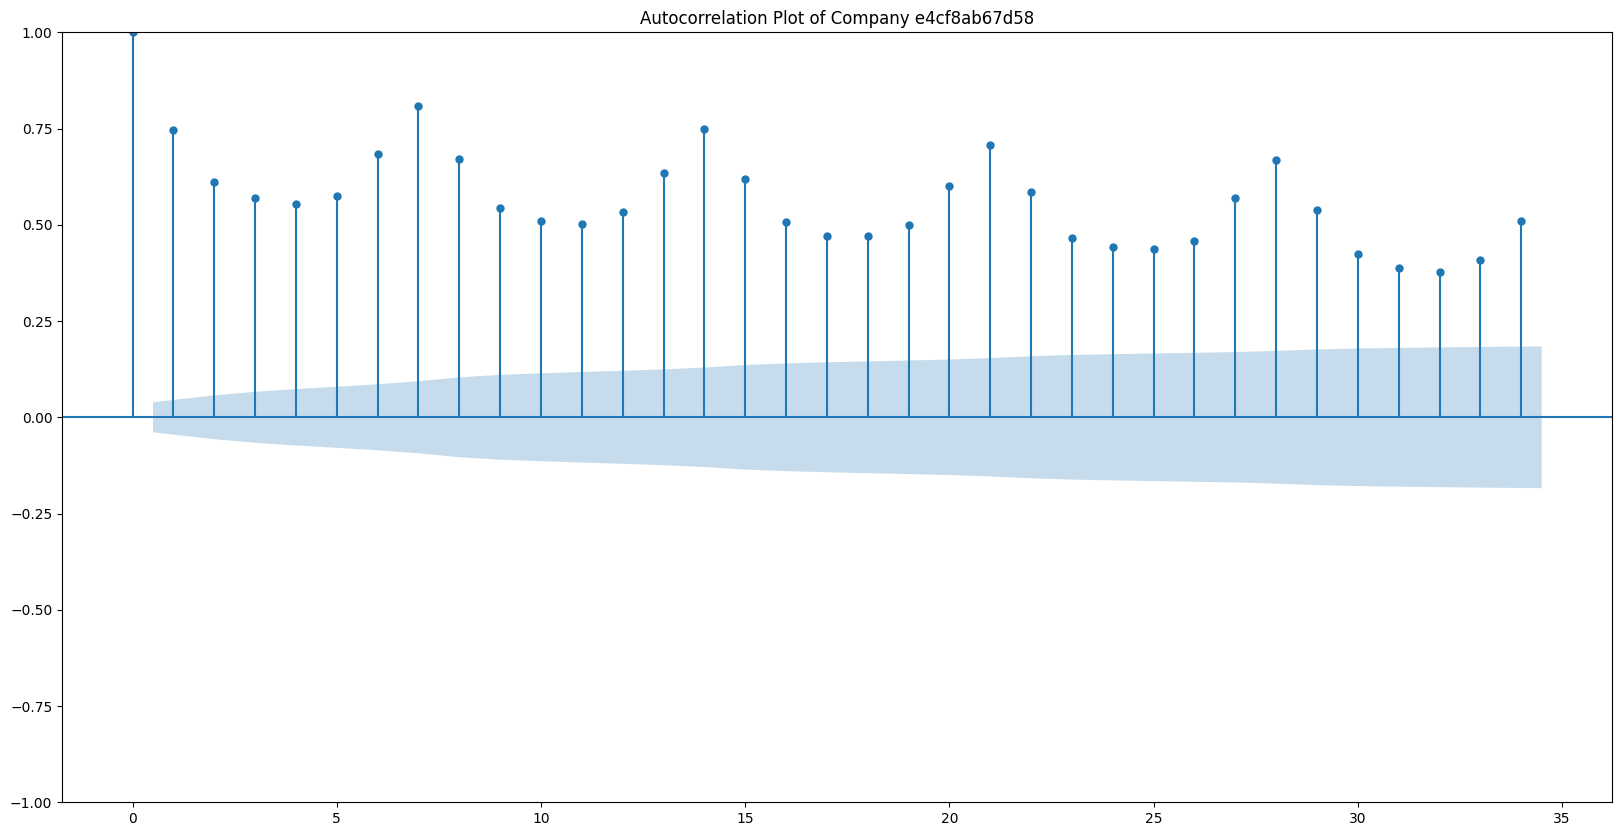

<Figure size 2000x1000 with 0 Axes>

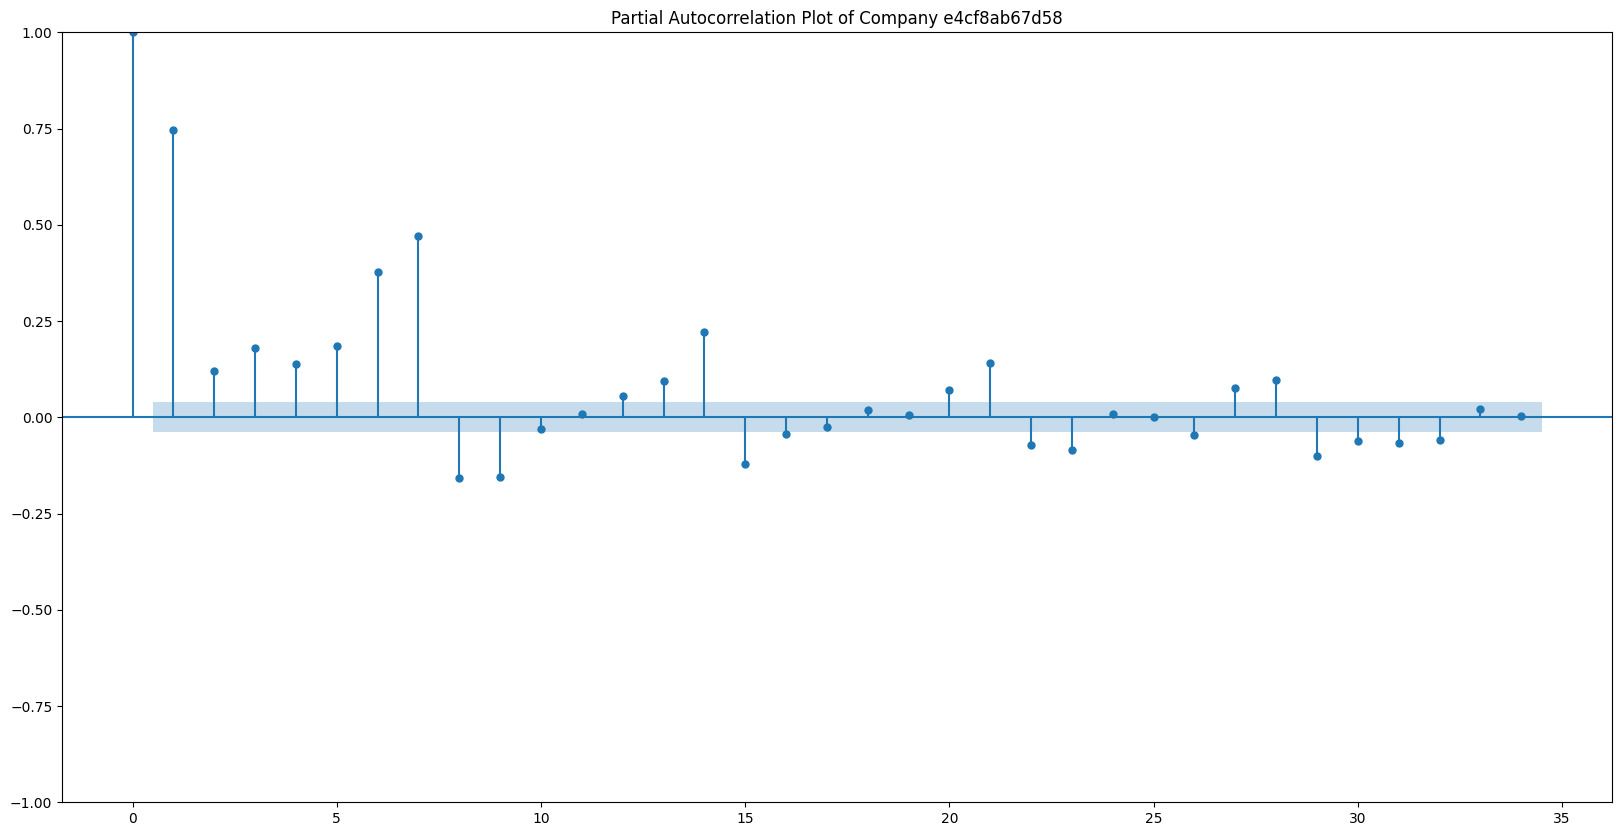

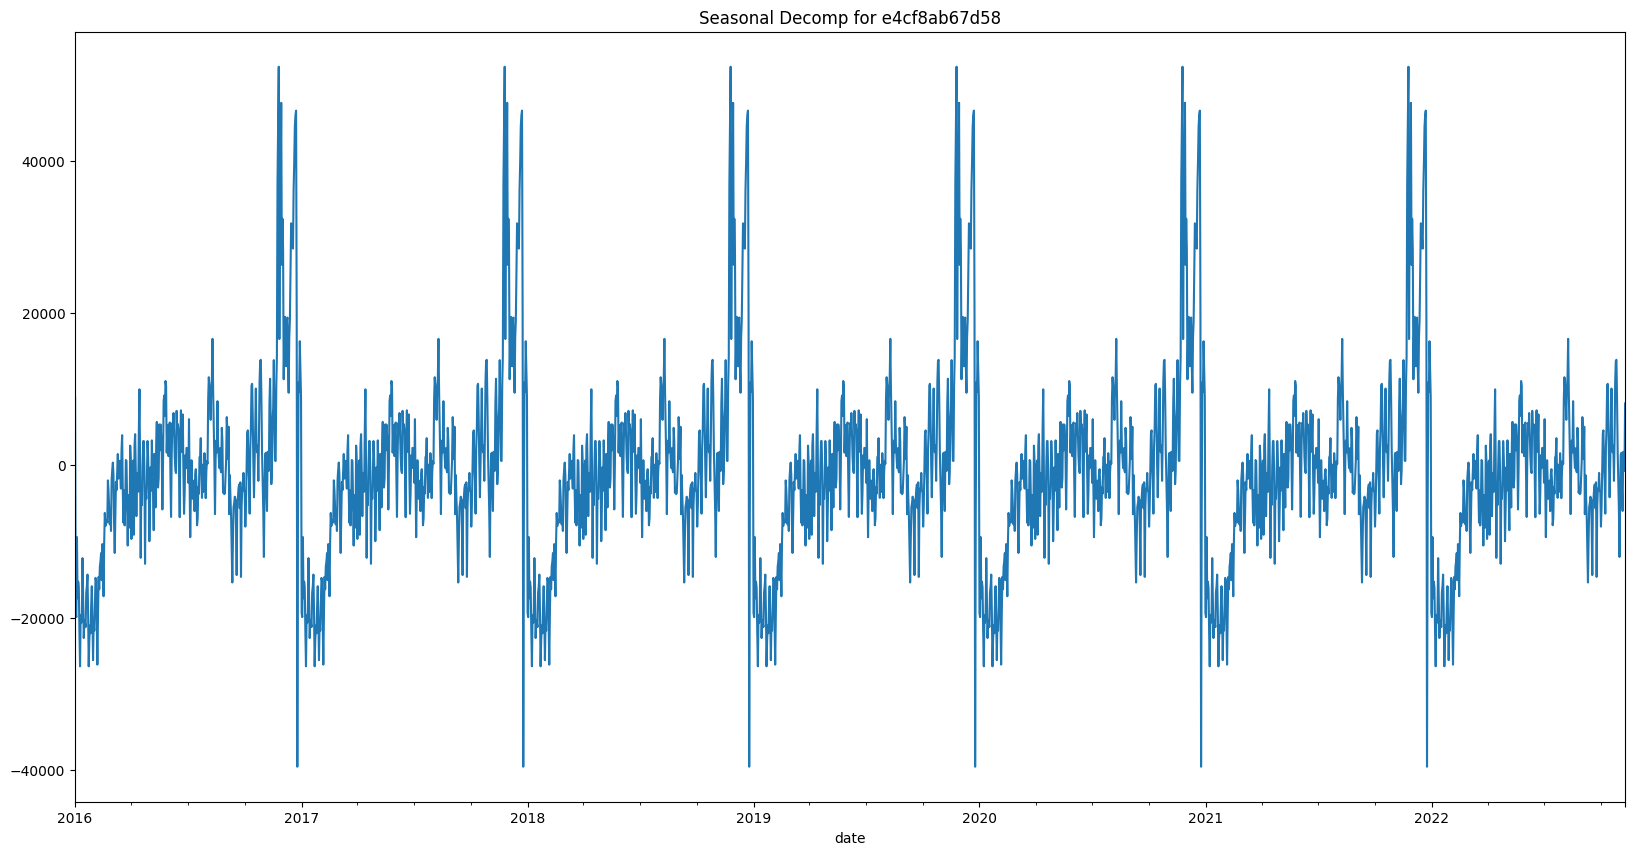

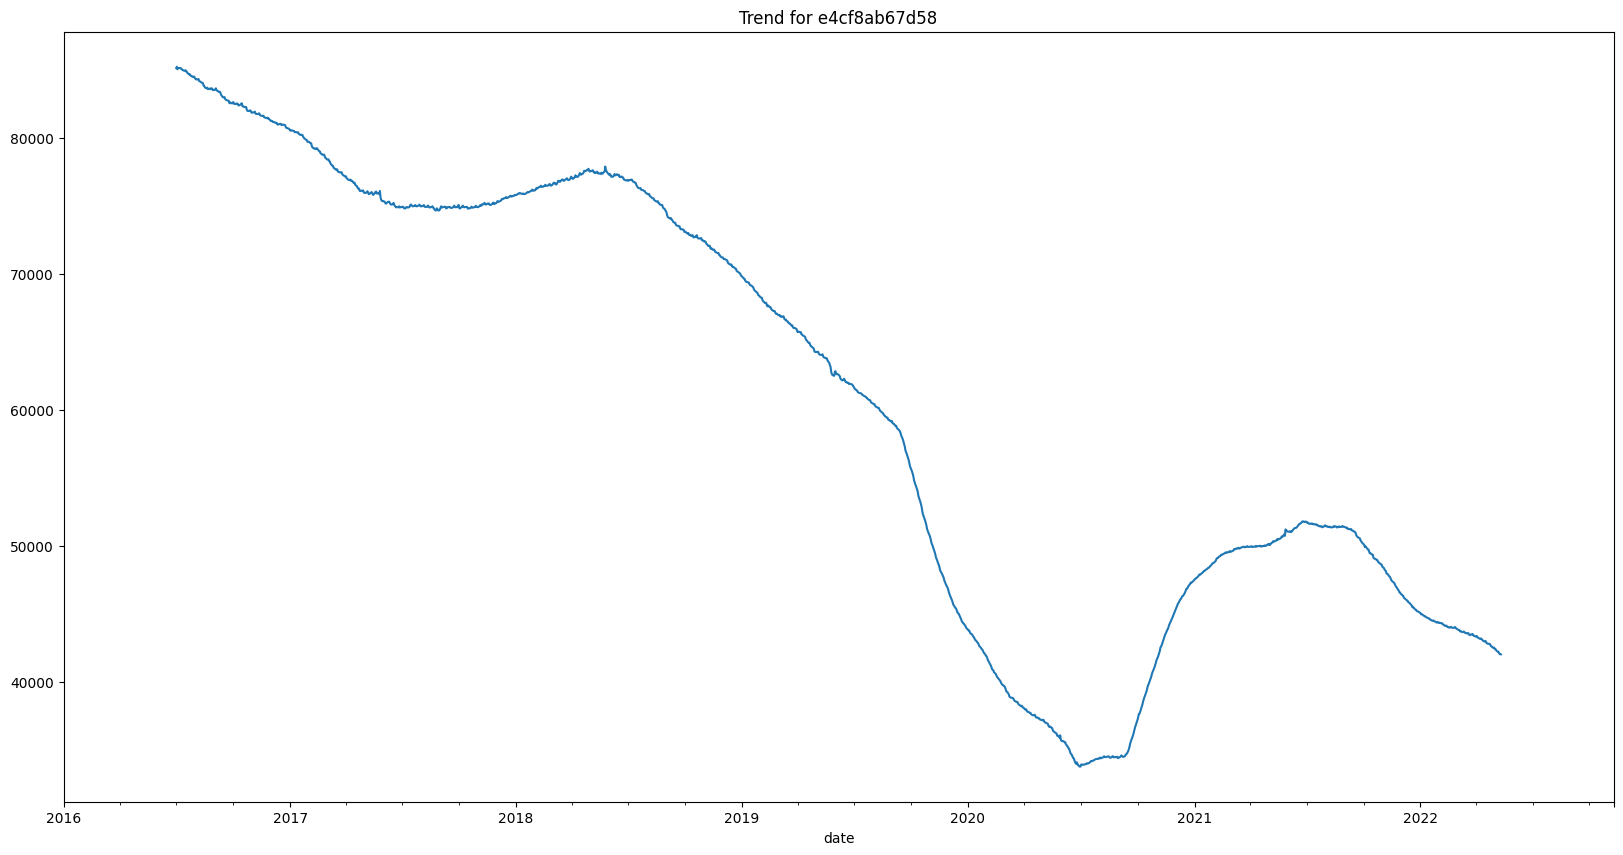

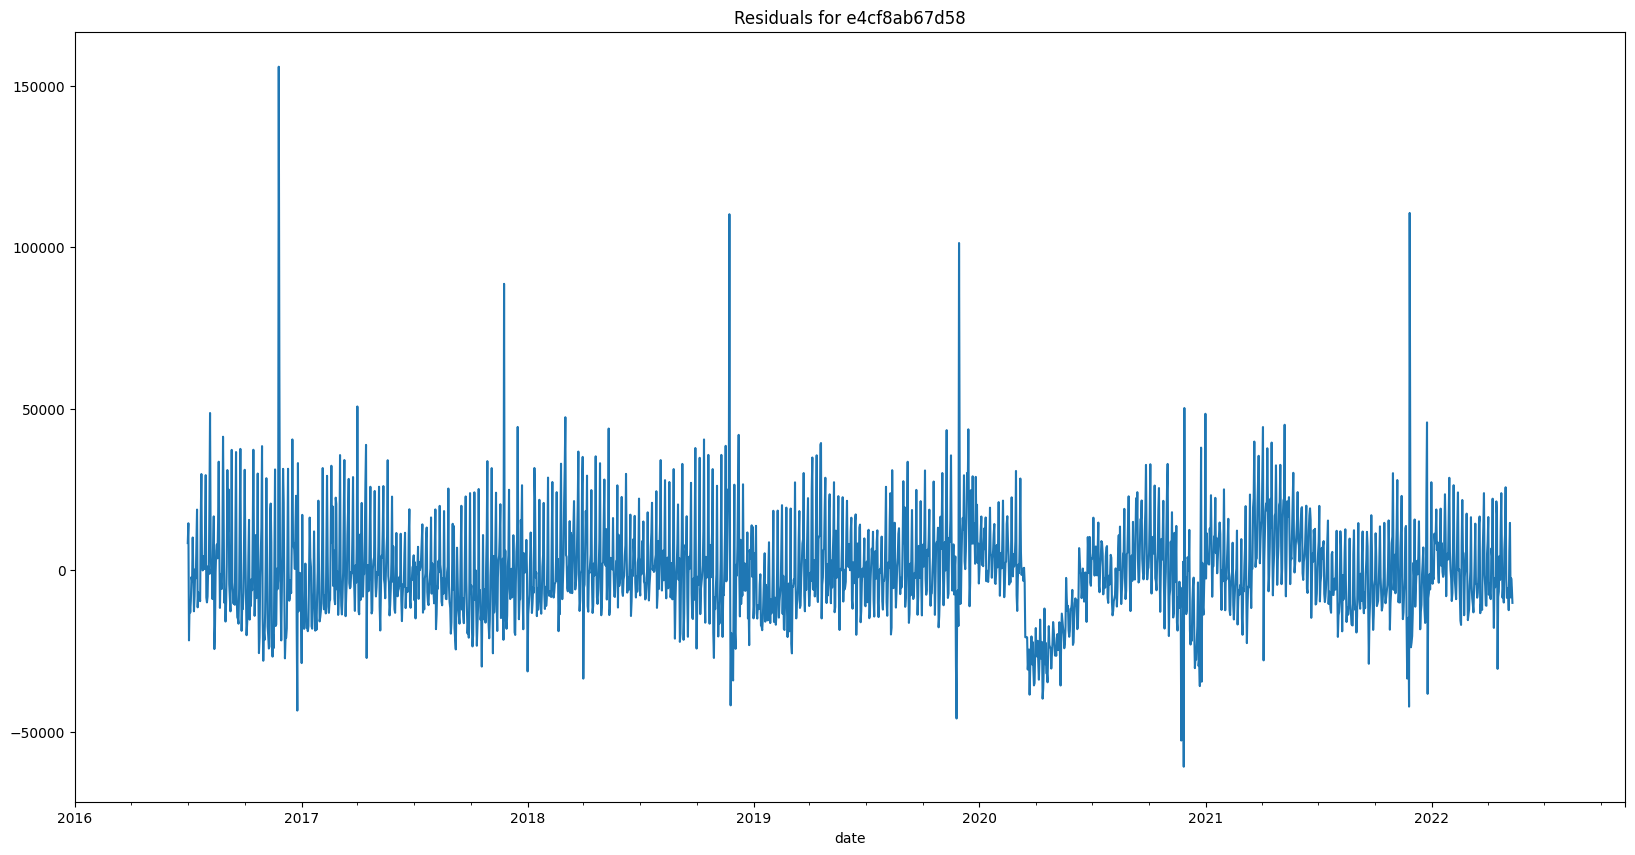

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20,10)

def run_decompose(cdf, company_id):
    data = cdf[cdf.company==cdf.company.unique()[company_id]].set_index('date')
    cid = data.company.iloc[0]
    data['data'].plot(title=f"Transaction Data for Company {cid}")
    sm.graphics.tsa.plot_acf(data['data'], title=f"Autocorrelation Plot of Company {cid}")
    plt.figure()
    sm.graphics.tsa.plot_pacf(data['data'], title=f"Partial Autocorrelation Plot of Company {cid}")
    plt.figure()
    seasonal_decompose(data['data'], period=365).seasonal.plot(title=f"Seasonal Decomp for {cid}")
    plt.figure()
    seasonal_decompose(data['data'], period=365).trend.plot(title=f"Trend for {cid}")
    plt.figure()
    seasonal_decompose(data['data'], period=365).resid.plot(title=f"Residuals for {cid}")


run_decompose(cdf, 2)

<h3> Pinpointing Anomalous Regions with STL </h3>

<Figure size 2000x1000 with 0 Axes>

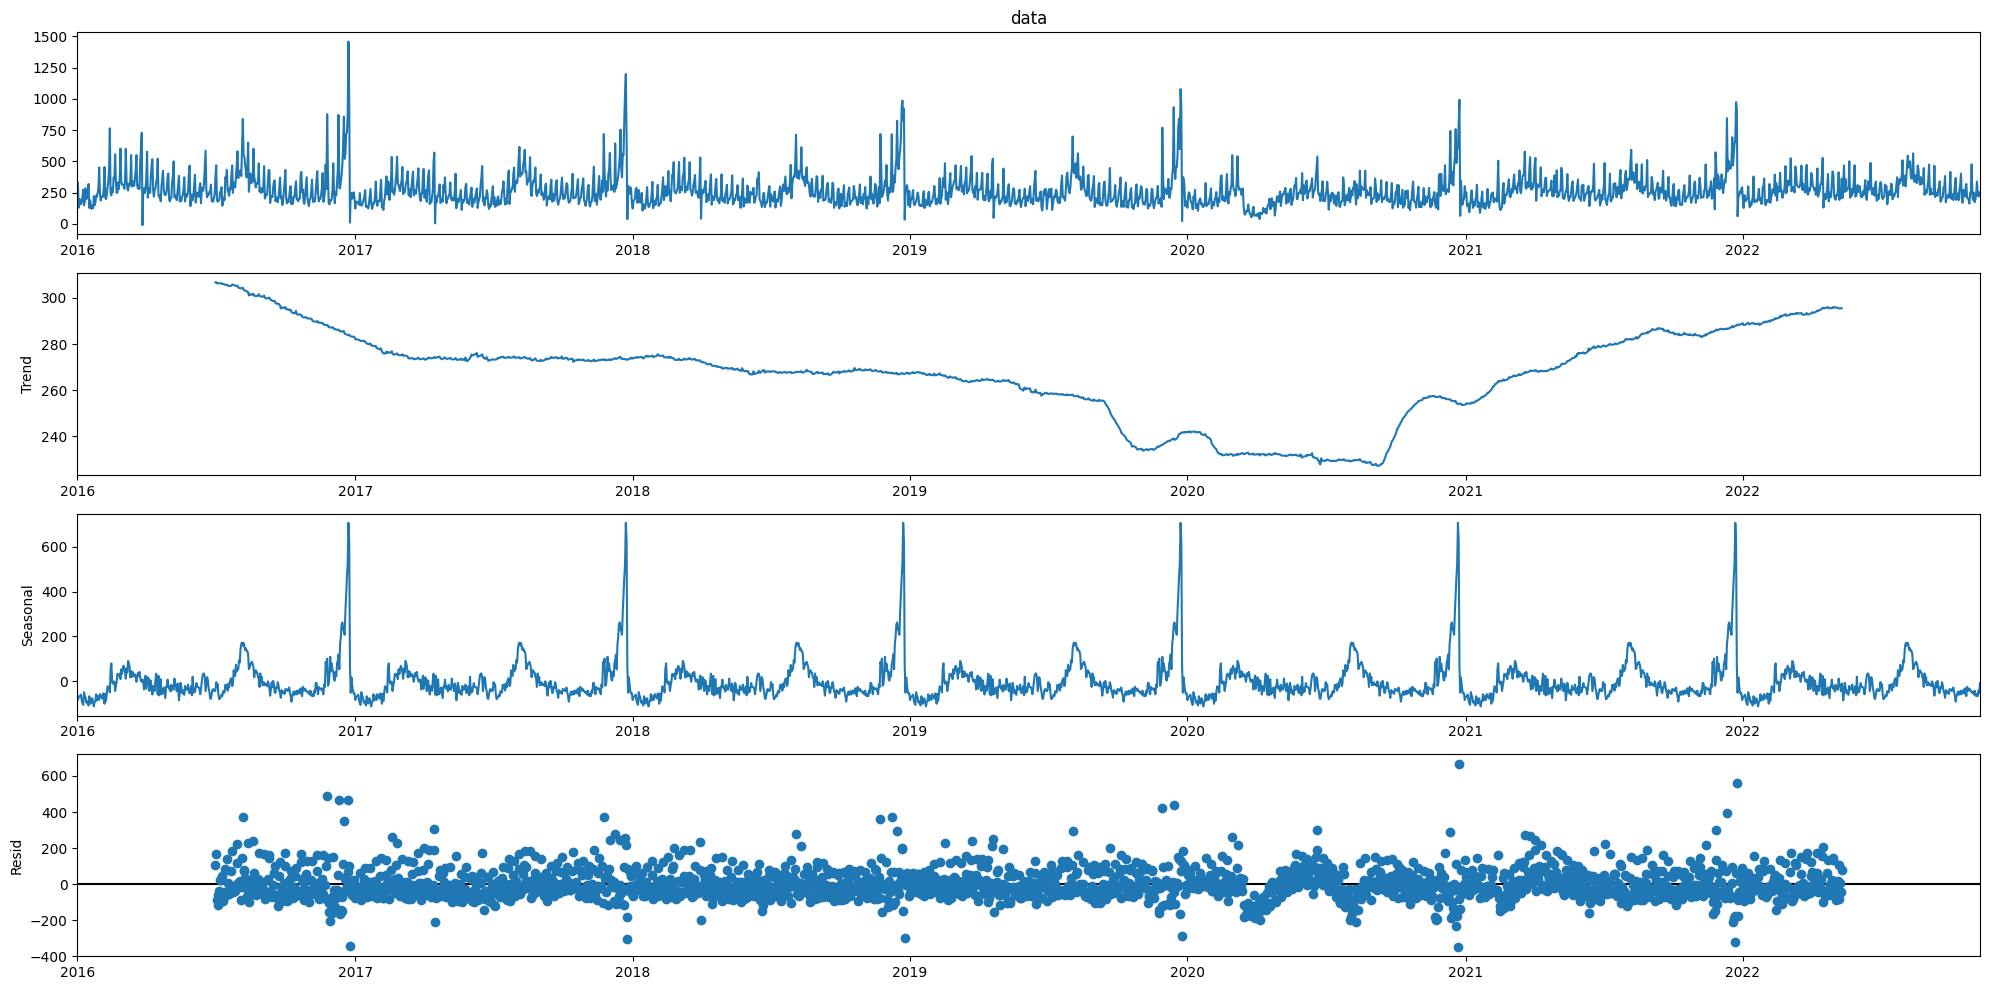

In [17]:
company_id = 1
data = cdf[cdf.company==cdf.company.unique()[company_id]].set_index('date')
cid = data.company.iloc[0]
plt.figure()
stl = seasonal_decompose(data['data'], period=365)
stl.plot()
fig = plt.gcf()
fig.tight_layout()


<AxesSubplot:title={'center':'Residuals'}, xlabel='date'>

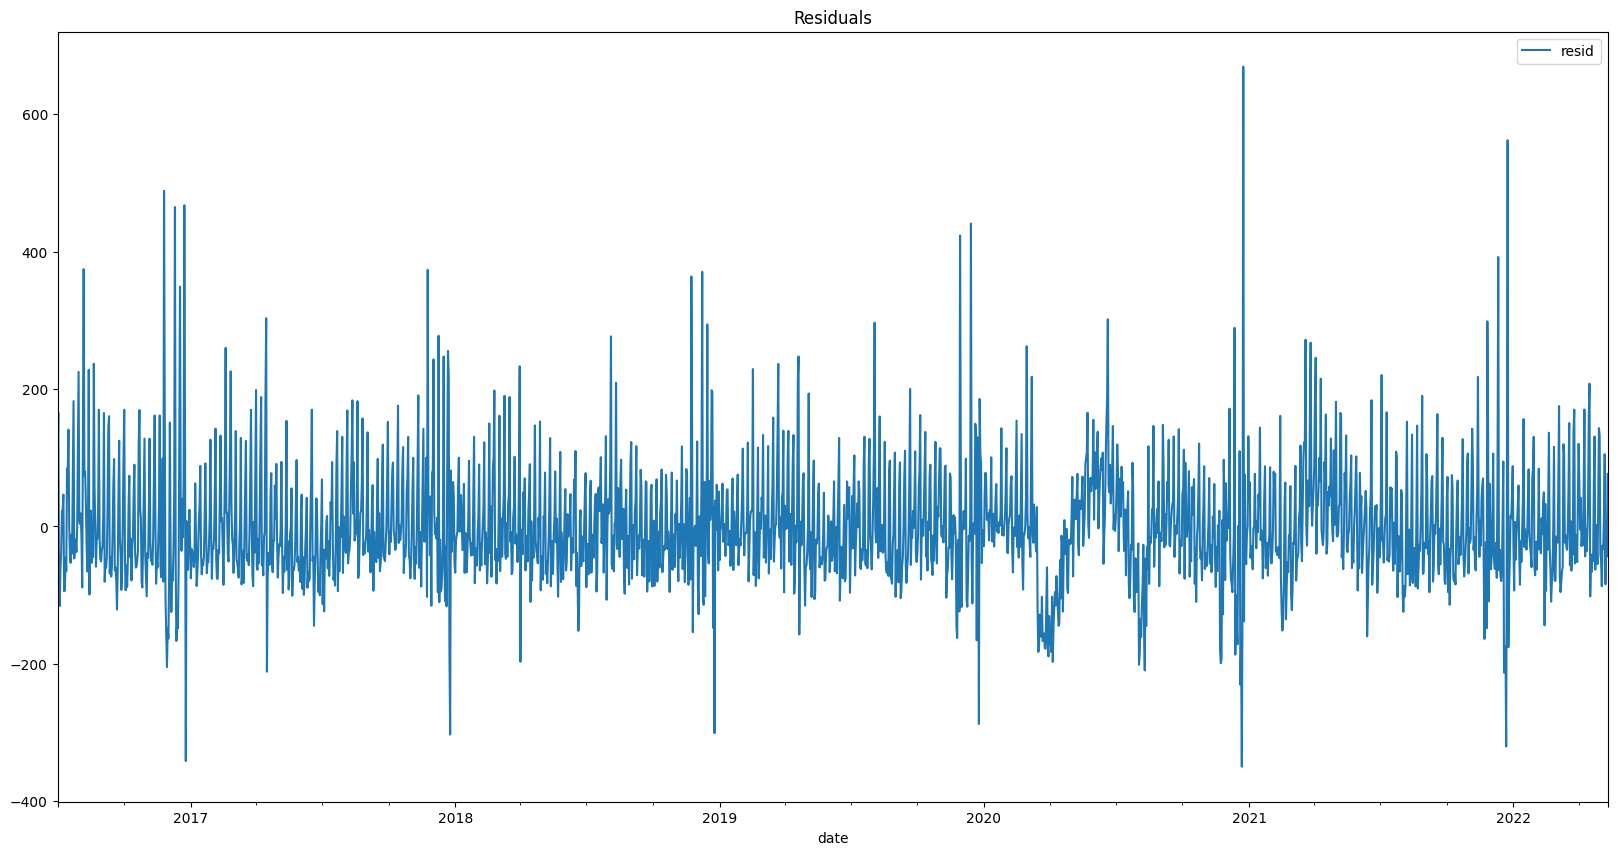

In [29]:
residuals = pd.DataFrame(stl.resid[~stl.resid.isna()])
residuals.plot(title="Residuals")

In [37]:
#goal: pinpoint anomalous windows given window size using particularly high residuals
# basic way; z-scoring
window_size = 10

window_avg_resid = residuals.rolling(window_size).mean().dropna() #drop NA means rolling ends on last day
window_avg_resid

,resid
date,
2016-07-10,-3.417840
2016-07-11,-23.382046
2016-07-12,-44.491273
2016-07-13,-41.911400
2016-07-14,-21.873700
...,...
2022-05-07,18.708998
2022-05-08,7.862862
2022-05-09,-5.946944


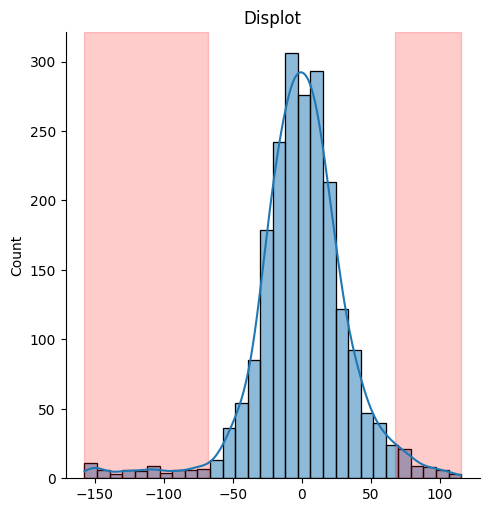

In [38]:
def reg_hist(plot_data):
    data_mean, data_std = plot_data.mean(), plot_data.std()
    cut_off = data_std * 2
    lower, upper = data_mean - cut_off, data_mean + cut_off

    sns.displot(plot_data, bins=30, kde=True) #kernel density estimation
    plt.axvspan(xmin=lower, xmax=plot_data.min(), alpha=0.2, color='red')
    plt.axvspan(xmin=upper, xmax=plot_data.max(), alpha=0.2, color='red')
    plt.title("Displot")

    return abs(plot_data-data_mean) > cut_off #beyond std devs

anomalous_resid = reg_hist(window_avg_resid.loc[:, "resid"].values)
plt.show()

In [89]:
awindows = window_avg_resid[anomalous_resid].reset_index()
awindows = awindows.rename(columns={"date":"end_date"})
awindows = awindows.assign(start_date = awindows.end_date - pd.Timedelta(days=10)).loc[:, ["start_date", "end_date"]]
awindows

,start_date,end_date
0,2016-07-27,2016-08-06
1,2016-07-28,2016-08-07
2,2016-07-29,2016-08-08
3,2016-08-03,2016-08-13
4,2016-08-04,2016-08-14
...,...,...
112,2021-04-01,2021-04-11
113,2021-04-02,2021-04-12
114,2021-12-11,2021-12-21
115,2021-12-12,2021-12-22


In [100]:
def get_resid_from_dates(x):
    start = x[0]
    end = x[1]
    start_index = np.where(residuals.index == start)[0][0]
    end_index = np.where(residuals.index == end)[0][0]

    return residuals.iloc[start_index:end_index, :]
    
replot_dfs = awindows.apply(get_resid_from_dates, axis=1)

In [110]:
replot_dfs[0].values.re

array([[-37.20014807],
       [ -3.54911745],
       [117.33426268],
       [224.95527963],
       [  7.34844102],
       [  3.43315805],
       [ 18.98207648],
       [-18.73406592],
       [-88.79007972],
       [146.29978255]])

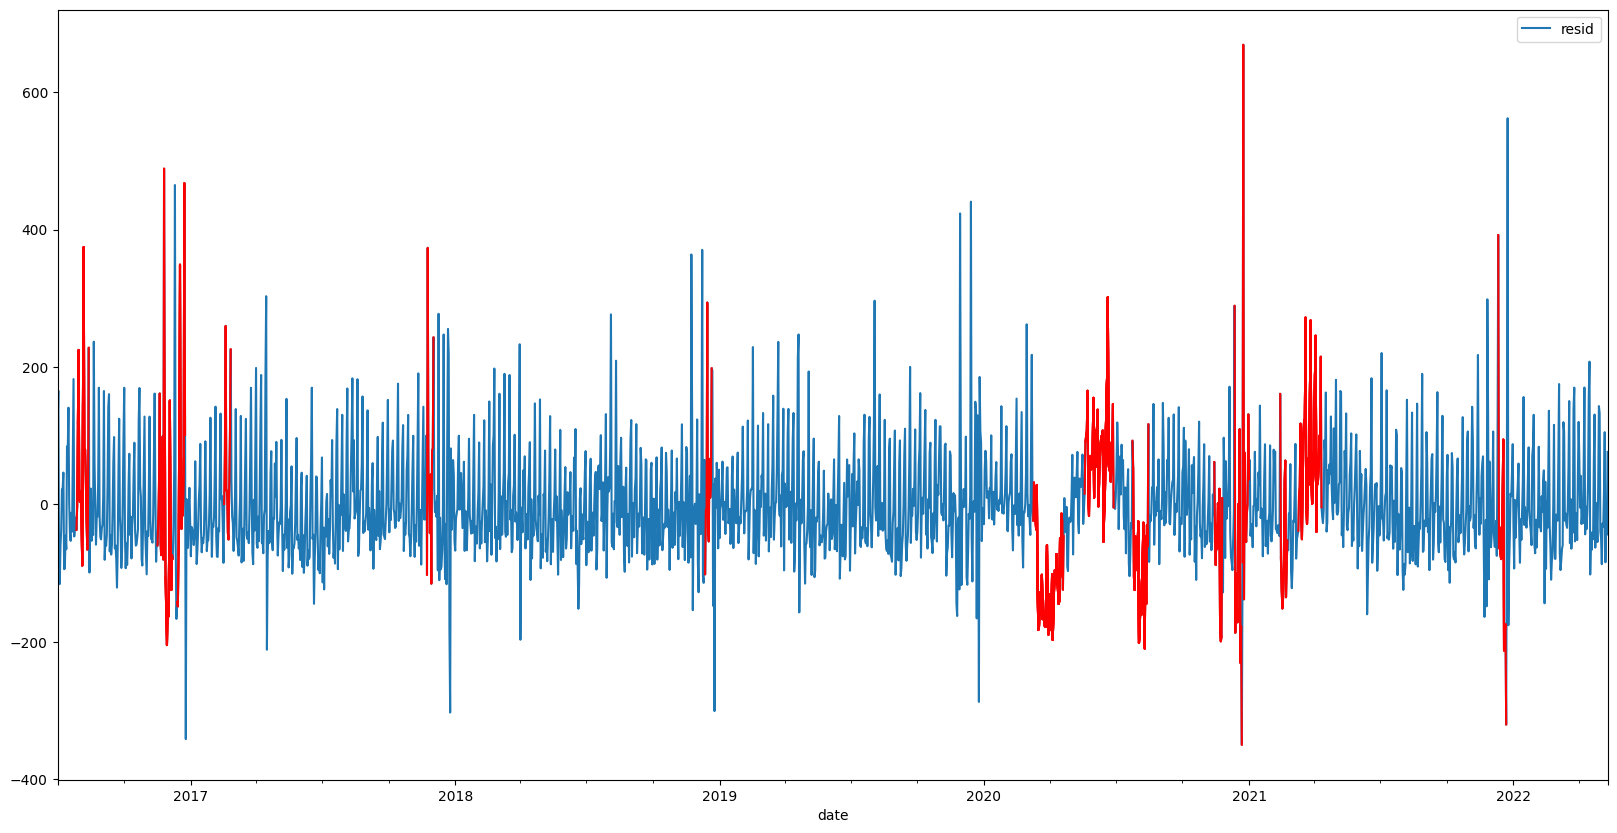

In [111]:
residuals.plot()
for anom in replot_dfs:
    plt.plot(anom.index, anom.values.reshape(1,-1)[0], color="red")

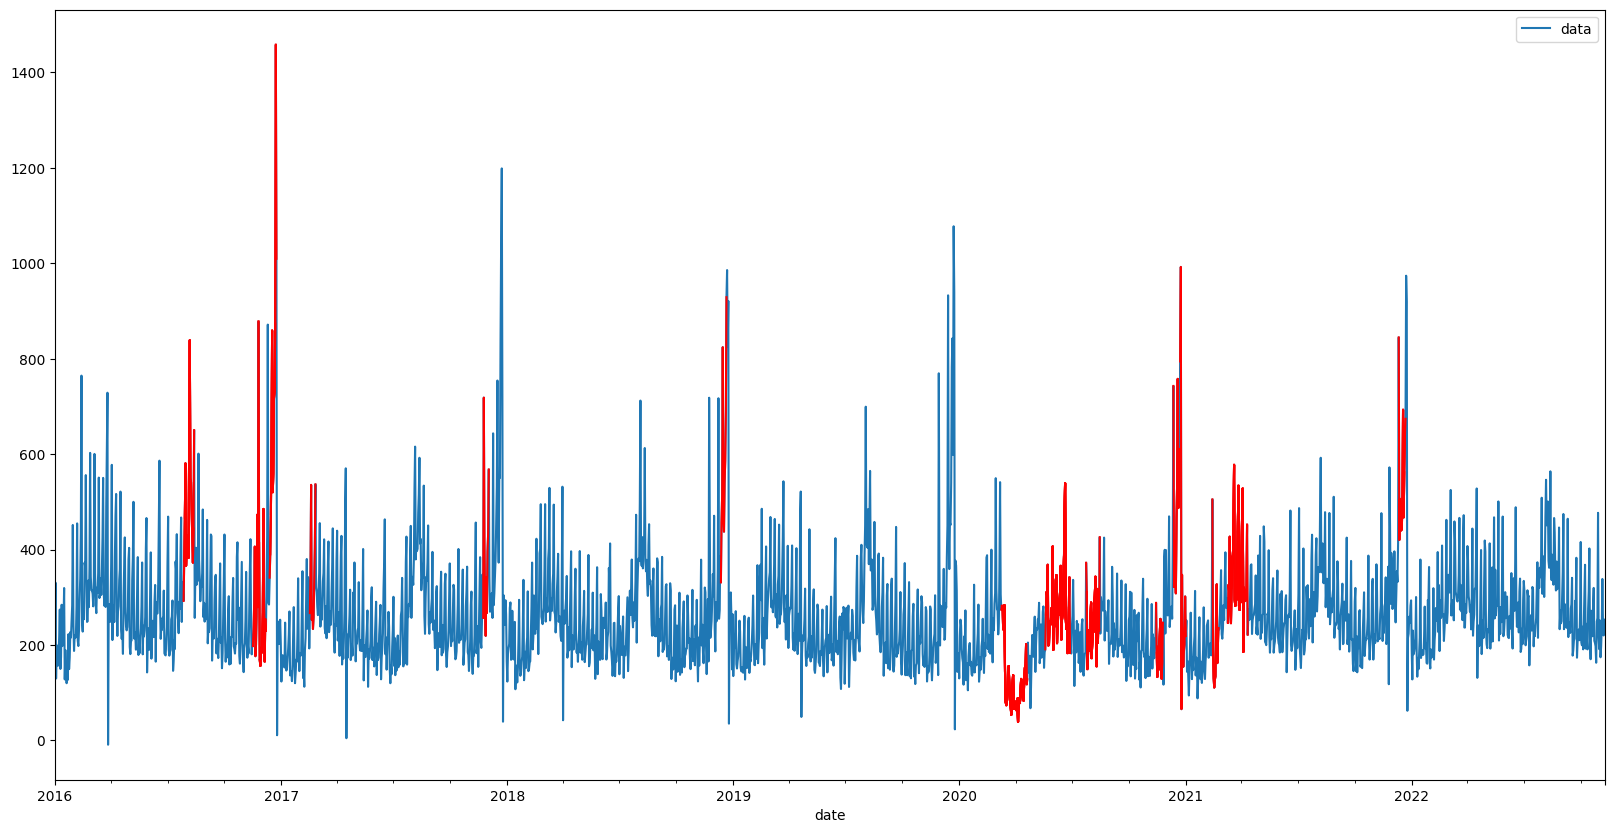

In [122]:
# plot transactions
transactions = data.loc[data.company==cid, ["data"]]
transactions.plot()
for anom in replot_dfs:
    this_anom = transactions.loc[anom.index]
    plt.plot(anom.index, this_anom.values.reshape(1,-1)[0], color="red")

<h3> Continuing Credit EDA </h3>

In [3]:
print(cdf.groupby('month')['data'].mean())

month
1     37221.201794
2     39499.614054
3     43218.483865
4     44889.556693
5     47185.668088
6     47377.974492
7     46744.543951
8     45455.191116
9     44862.898622
10    45289.020022
11    44450.557720
12    44811.584667
Name: data, dtype: float64


In [4]:
g = cdf.groupby('company')['data']
min_, max_ = g.transform('min'), g.transform('max')
cdf['data_scale'] = (cdf['data'] - min_) / (max_ - min_)
cdf

,company,date,data,month,quarter,data_scale
0,ef1bcca724f3,2016-01-01,266648.924500,1,1,0.298810
1,ef1bcca724f3,2016-01-02,330109.961300,1,1,0.375720
2,ef1bcca724f3,2016-01-03,248299.827200,1,1,0.276572
3,ef1bcca724f3,2016-01-04,146428.339600,1,1,0.153111
4,ef1bcca724f3,2016-01-05,146854.815500,1,1,0.153628
...,...,...,...,...,...,...
116654,e2415cb7f63d,2022-11-05,1149.371612,11,4,0.208974
116655,e2415cb7f63d,2022-11-06,890.458833,11,4,0.163990
116656,e2415cb7f63d,2022-11-07,1233.454763,11,4,0.223583
116657,e2415cb7f63d,2022-11-08,2478.464933,11,4,0.439893


In [5]:
print(cdf.groupby('month')['data_scale'].mean())

month
1     0.243158
2     0.257268
3     0.269286
4     0.270671
5     0.280576
6     0.287241
7     0.282683
8     0.277171
9     0.271123
10    0.265779
11    0.276234
12    0.290832
Name: data_scale, dtype: float64


<AxesSubplot:title={'center':'Seasonal Decomp Trend'}, xlabel='date'>

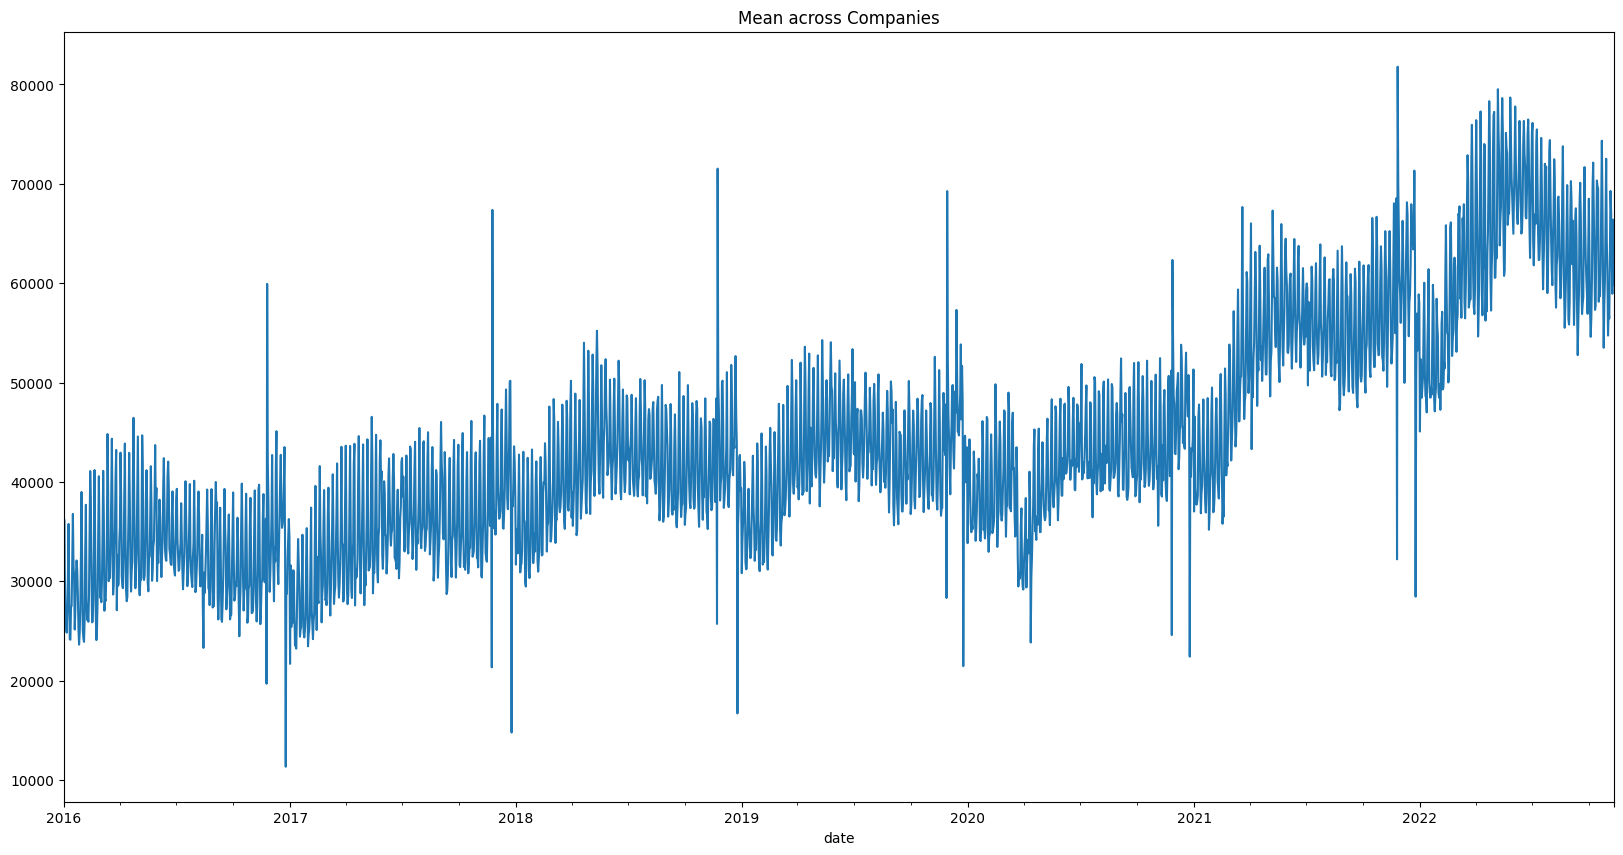

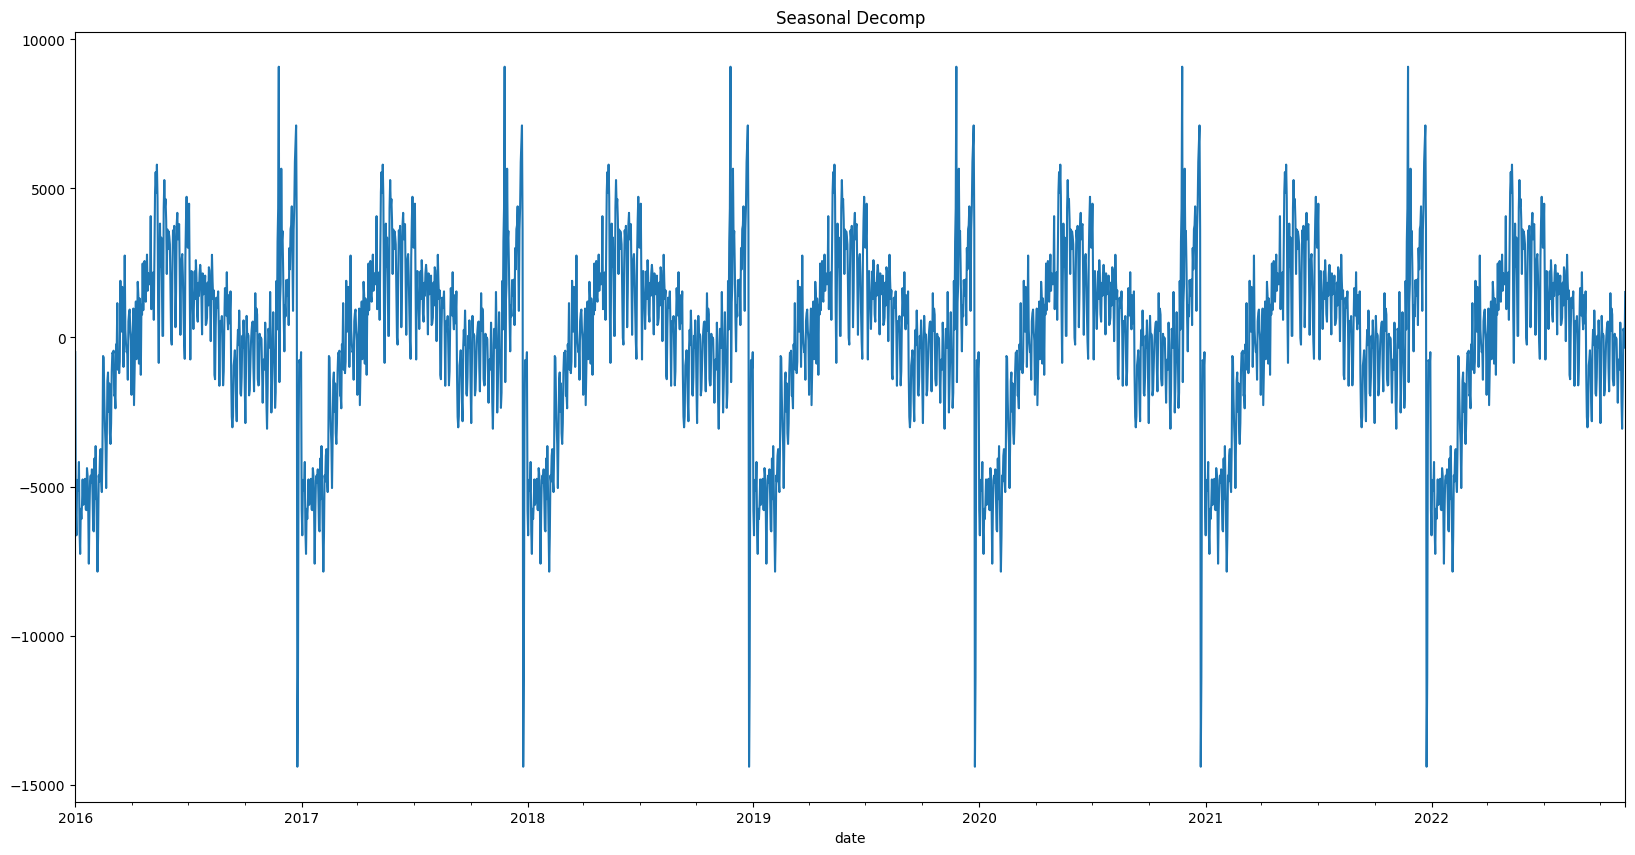

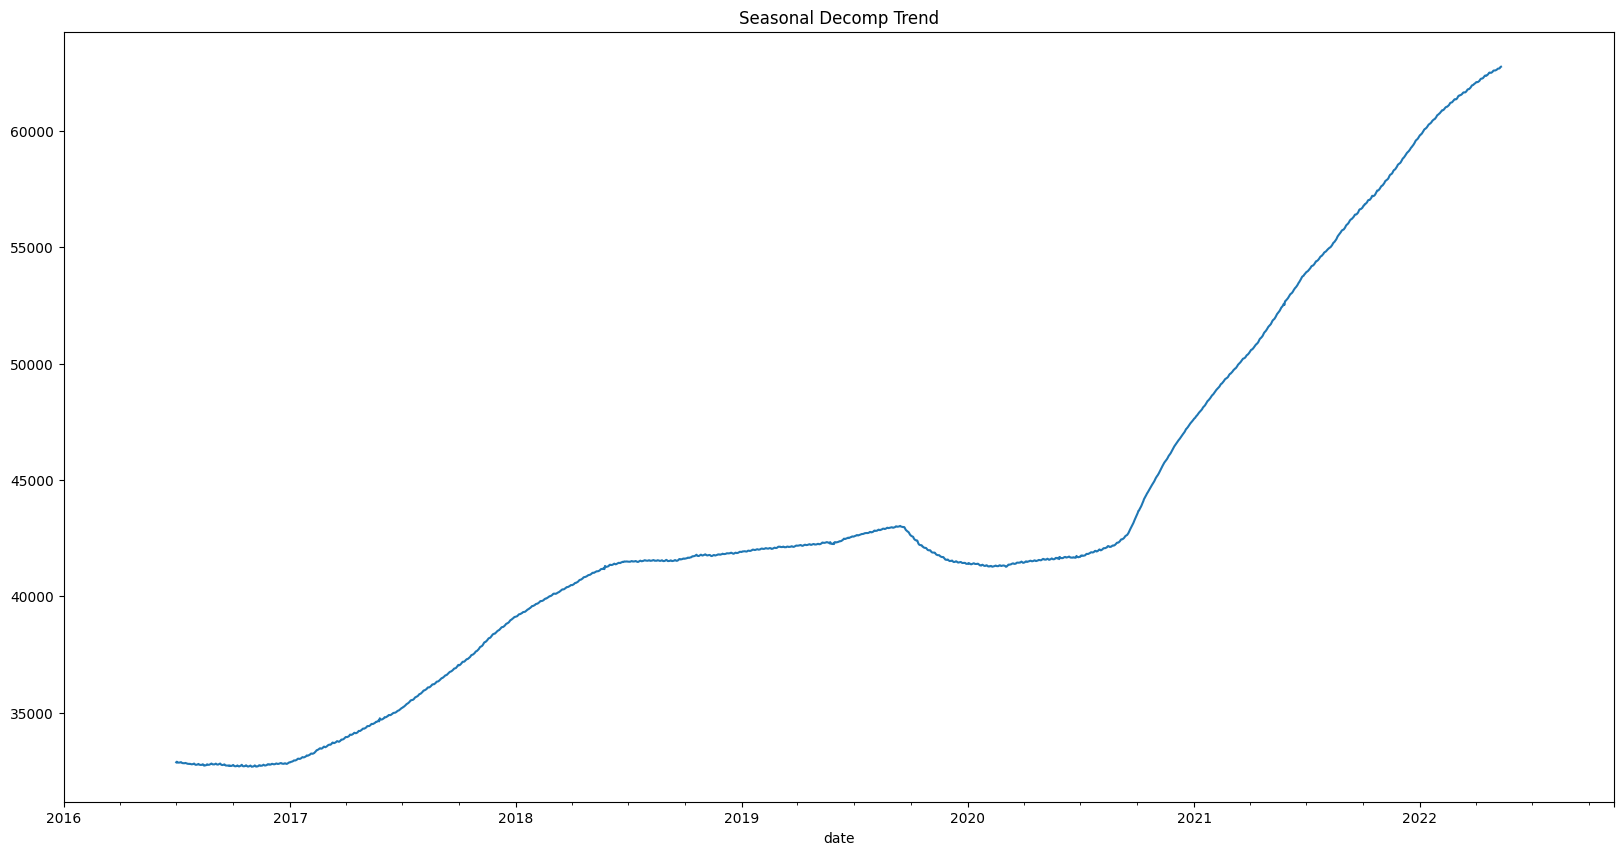

In [6]:
import numpy as np
gd = cdf.groupby(['date'])[['data']].mean()
gd.data.plot(title="Mean across Companies")
plt.figure()
seasonal_decompose(gd['data'], period=365).seasonal.plot(title="Seasonal Decomp")
plt.figure()
seasonal_decompose(gd['data'], period=365).trend.plot(title="Seasonal Decomp Trend")



<AxesSubplot:title={'center':'Seasonal Decomp Trend'}, xlabel='date'>

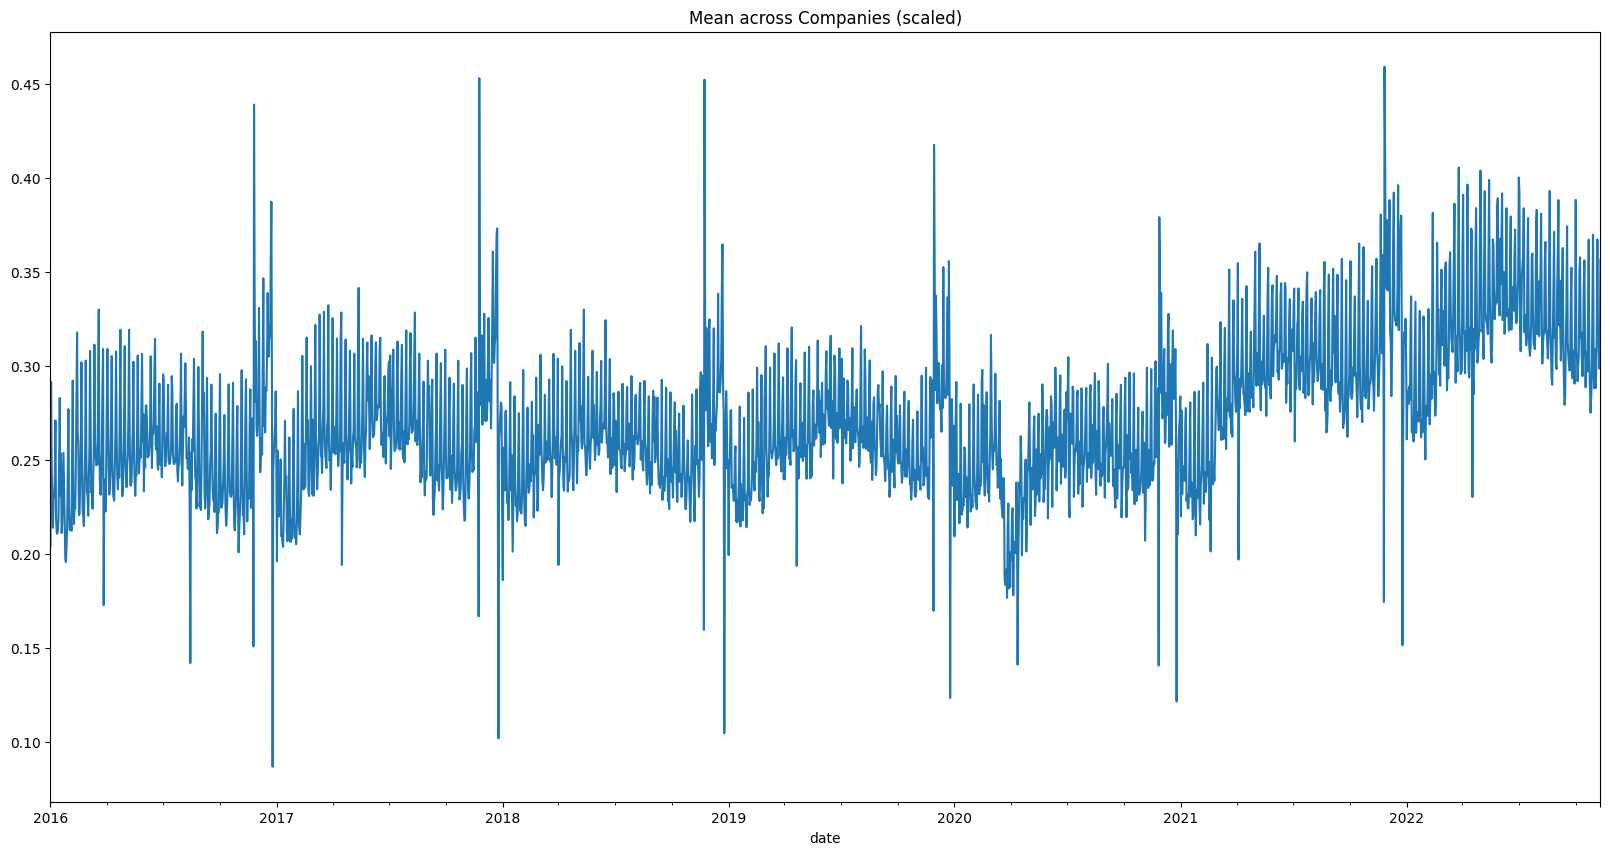

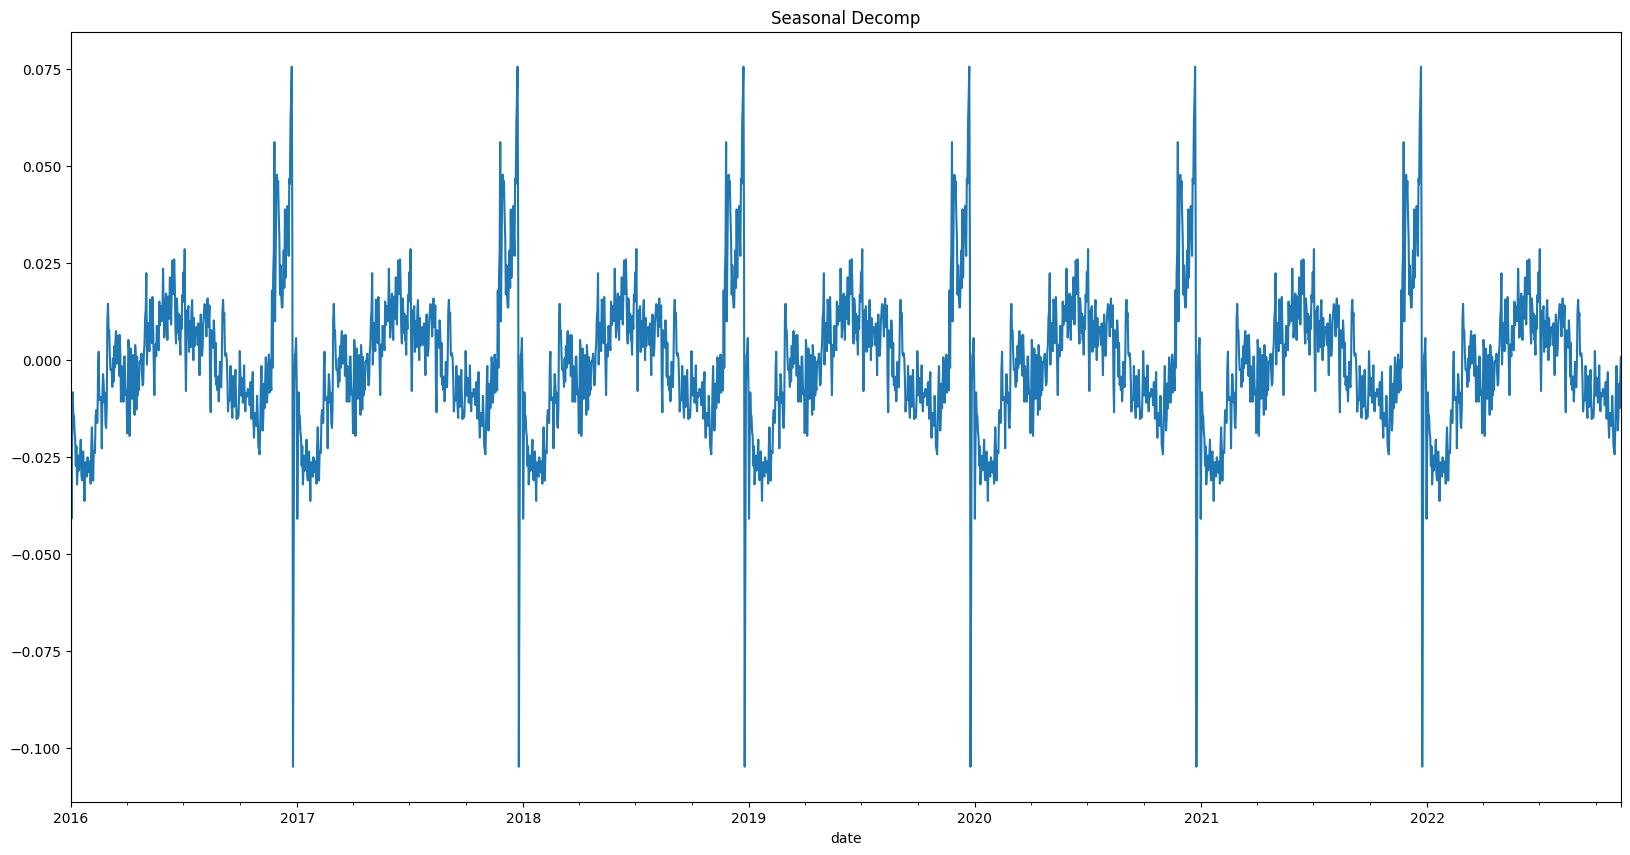

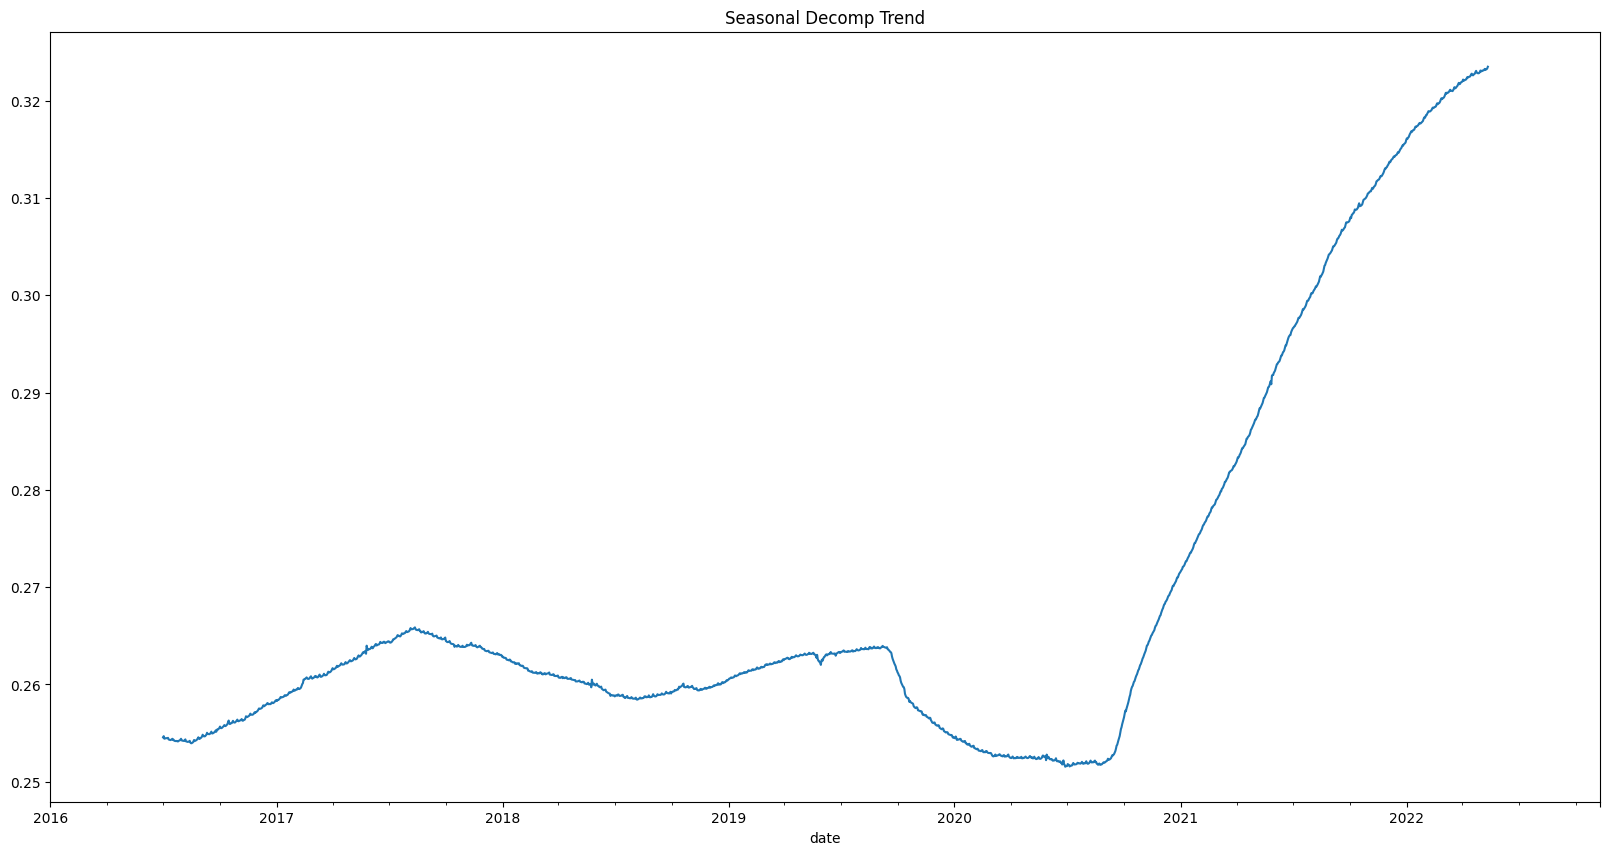

In [7]:
import numpy as np
gd = cdf.set_index('date').groupby(['date'])[['data_scale']].mean()
gd.data_scale.plot(title="Mean across Companies (scaled)")
plt.figure()
seasonal_decompose(gd['data_scale'], period=365).seasonal.plot(title="Seasonal Decomp")
plt.figure()
seasonal_decompose(gd['data_scale'], period=365).trend.plot(title="Seasonal Decomp Trend")



Text(0.5, 1.0, 'Histogram of Transactions By Company')

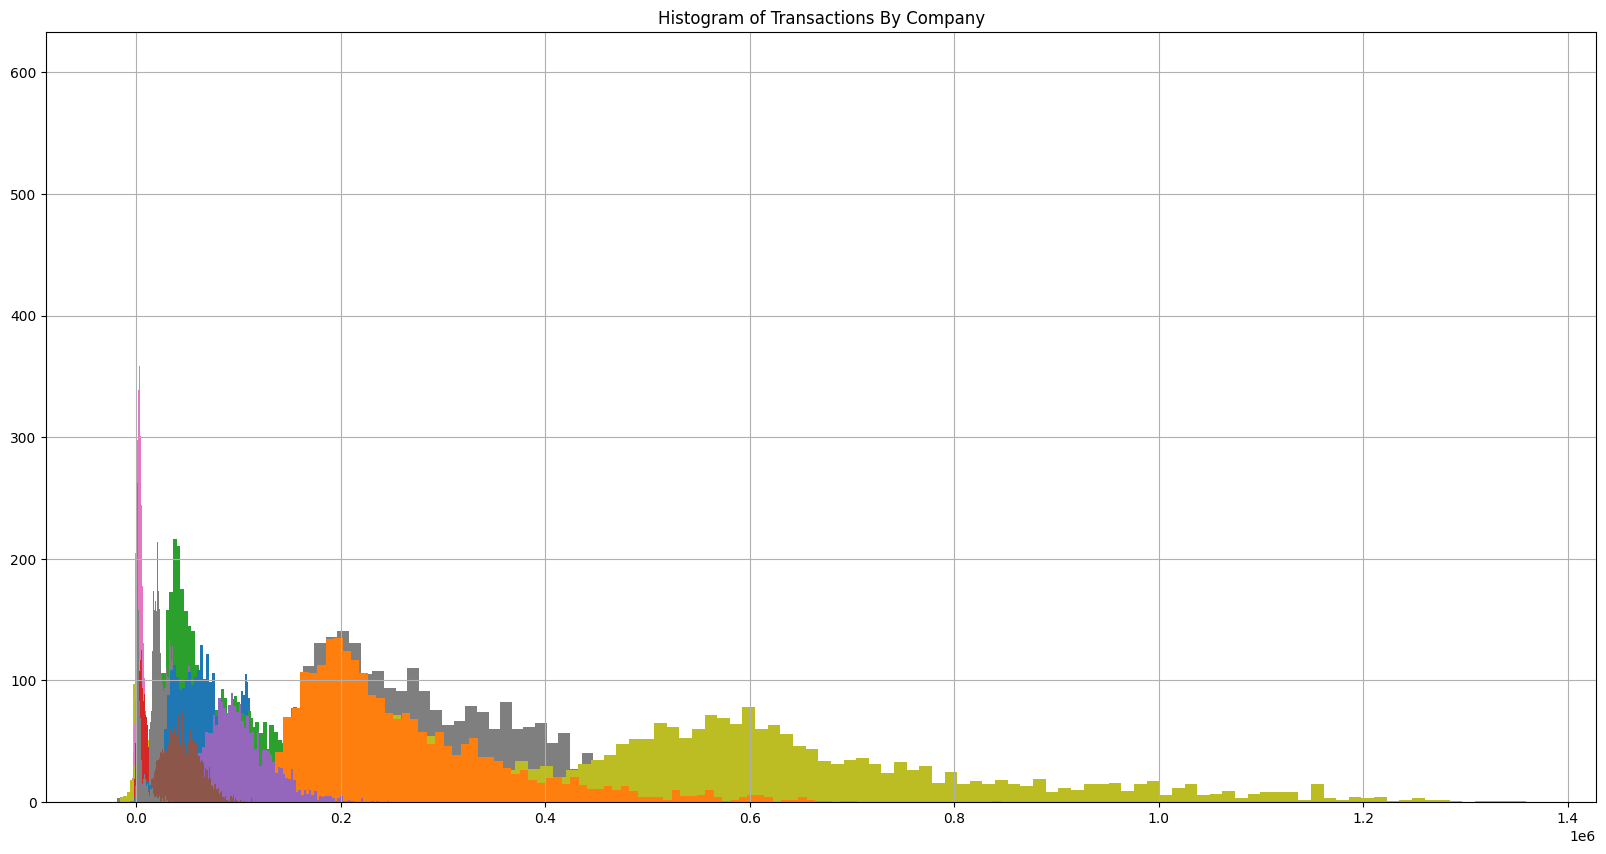

In [8]:
cdf.groupby('company').data.hist(bins=100)
plt.title("Histogram of Transactions By Company")

Text(0.5, 1.0, 'Histogram of Transactions By Company (Scaled)')

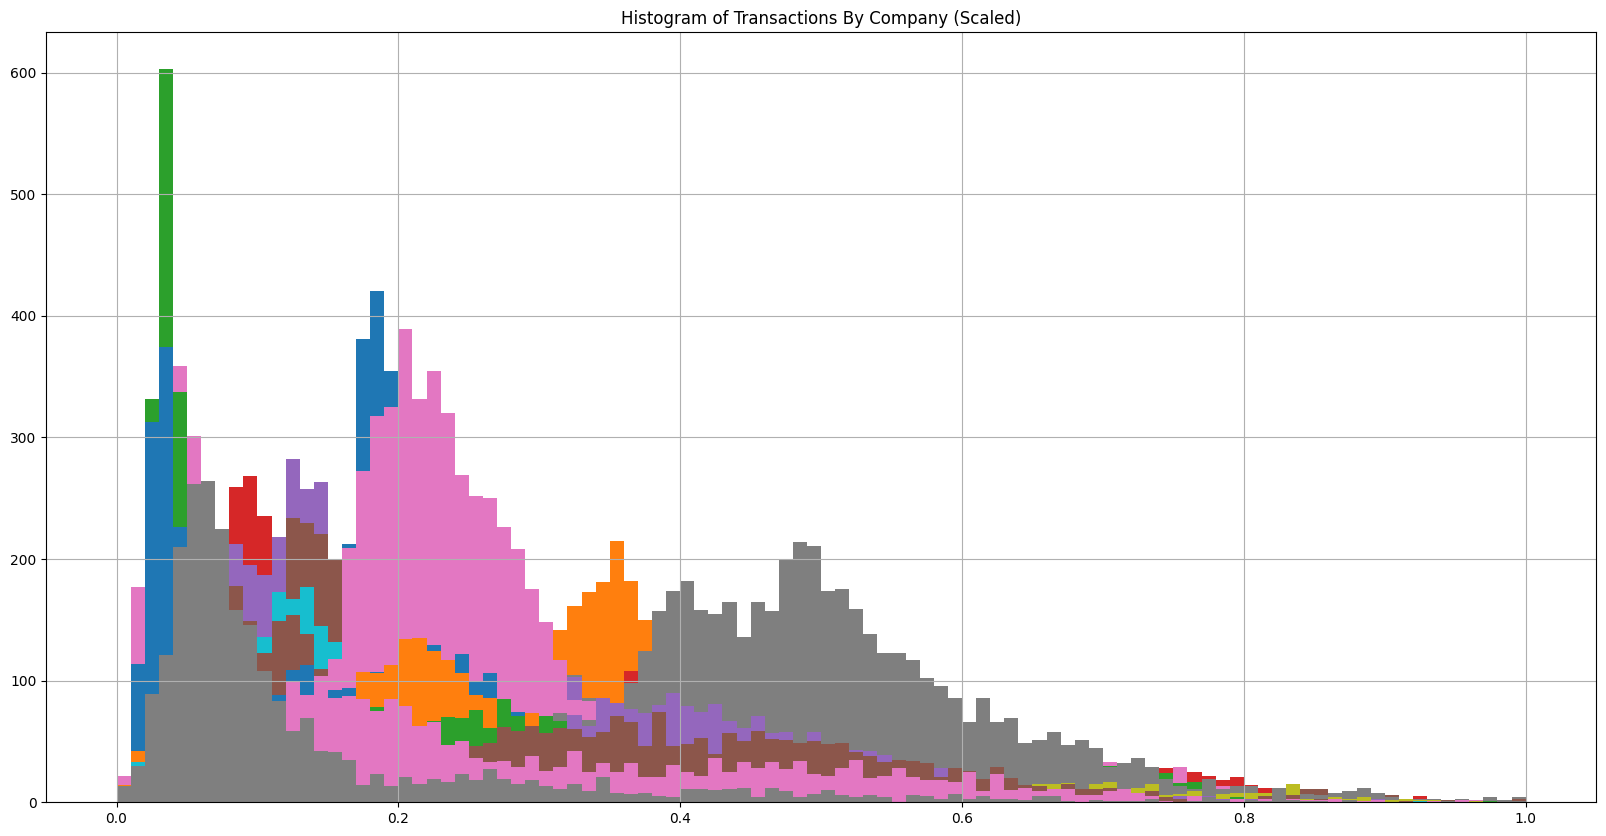

In [9]:
cdf.groupby('company').data_scale.hist(bins=100)
plt.title("Histogram of Transactions By Company (Scaled)")